In [1]:
#!pip install kornia --upgrade
#!pip install pytorch_metric_learning

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import random
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from fastai2.basics import *
from fastcore import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastprogress import fastprogress
from fastai2.callback.mixup import *
from fastscript import *
import torchvision as tv
import kornia as K
import gc
from pytorch_metric_learning import losses, miners

def imshow_torch(tensor, *kwargs):
    plt.figure()
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

In [2]:
train_ds_name = 'liberty'
val_ds_names = ['notredame', 'yosemite']

ds_root = '/home/old-ufo/datasets/Brown/'

In [3]:
import os
import numpy as np
from PIL import Image
from typing import Any, Callable, List, Optional, Tuple, Union

import torch
import torchvision
from torchvision.datasets import VisionDataset

from torchvision.datasets.utils import download_url

from fastai2  import *


class PhotoTourRevisited(torchvision.datasets.VisionDataset):
    """`Learning Local Image Descriptors Data <http://phototour.cs.washington.edu/patches/default.htm>`_ Dataset.
    Args:
        root (string): Root directory where images are.
        name (string): Name of the dataset to load.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    urls = {
        'notredame_harris': [
            'http://matthewalunbrown.com/patchdata/notredame_harris.zip',
            'notredame_harris.zip',
            '69f8c90f78e171349abdf0307afefe4d'
        ],
        'yosemite_harris': [
            'http://matthewalunbrown.com/patchdata/yosemite_harris.zip',
            'yosemite_harris.zip',
            'a73253d1c6fbd3ba2613c45065c00d46'
        ],
        'liberty_harris': [
            'http://matthewalunbrown.com/patchdata/liberty_harris.zip',
            'liberty_harris.zip',
            'c731fcfb3abb4091110d0ae8c7ba182c'
        ],
        'notredame': [
            'http://icvl.ee.ic.ac.uk/vbalnt/notredame.zip',
            'notredame.zip',
            '509eda8535847b8c0a90bbb210c83484'
        ],
        'yosemite': [
            'http://icvl.ee.ic.ac.uk/vbalnt/yosemite.zip',
            'yosemite.zip',
            '533b2e8eb7ede31be40abc317b2fd4f0'
        ],
        'liberty': [
            'http://icvl.ee.ic.ac.uk/vbalnt/liberty.zip',
            'liberty.zip',
            'fdd9152f138ea5ef2091746689176414'
        ],
    }
    means = {'notredame': 0.4854, 'yosemite': 0.4844, 'liberty': 0.4437,
             'notredame_harris': 0.4854, 'yosemite_harris': 0.4844, 'liberty_harris': 0.4437}
    stds = {'notredame': 0.1864, 'yosemite': 0.1818, 'liberty': 0.2019,
            'notredame_harris': 0.1864, 'yosemite_harris': 0.1818, 'liberty_harris': 0.2019}
    lens = {'notredame': 468159, 'yosemite': 633587, 'liberty': 450092,
            'liberty_harris': 379587, 'yosemite_harris': 450912, 'notredame_harris': 325295}
    image_ext = 'bmp'
    info_file = 'info.txt'
    matches_files = 'm50_100000_100000_0.txt'
    img_info_files = 'interest.txt'

    def __init__(
            self, root: str, name: str, train: bool = False,
        transform: Optional[Callable] = None, download: bool = False
    ) -> None:
        super(PhotoTourRevisited, self).__init__(root)
        self.name = name
        self.data_dir = os.path.join(self.root, name)
        self.data_down = os.path.join(self.root, '{}.zip'.format(name))
        self.data_file = os.path.join(self.root, '{}.pt'.format(name))

        self.train = train
        self.mean = self.means[name]
        self.std = self.stds[name]

        if download:
            self.download()

        if not self._check_datafile_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        # load the serialized data
        self.data, self.labels, self.matches, self.img_idxs = torch.load(self.data_file)

    def __getitem__(self, index: int) -> Union[torch.Tensor, Tuple[Any, Any, torch.Tensor]]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (data1, data2, matches)
        """
        data = self.data[index]
        if self.transform is not None:
            data = self.transform(data)
        if self.train:
            return data
        return data, self.labels[index], self.img_idxs[index]

    def __len__(self) -> int:
        return self.lens[self.name]


    def _check_datafile_exists(self) -> bool:
        return os.path.exists(self.data_file)

    def _check_downloaded(self) -> bool:
        return os.path.exists(self.data_dir)

    def download(self) -> None:
        if self._check_datafile_exists():
            print('# Found cached data {}'.format(self.data_file))
            return

        if not self._check_downloaded():
            # download files
            url = self.urls[self.name][0]
            filename = self.urls[self.name][1]
            md5 = self.urls[self.name][2]
            fpath = os.path.join(self.root, filename)

            download_url(url, self.root, filename, md5)

            print('# Extracting data {}\n'.format(self.data_down))

            import zipfile
            with zipfile.ZipFile(fpath, 'r') as z:
                z.extractall(self.data_dir)

            os.unlink(fpath)

        # process and save as torch files
        print('# Caching data {}'.format(self.data_file))

        dataset = (
            read_image_file(self.data_dir, self.image_ext, self.lens[self.name]),
            read_info_file(self.data_dir, self.info_file),
            read_matches_files(self.data_dir, self.matches_files),
            read_interest_file(self.data_dir, self.img_info_files)
        )

        with open(self.data_file, 'wb') as f:
            torch.save(dataset, f)

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")


def read_image_file(data_dir: str, image_ext: str, n: int) -> torch.Tensor:
    """Return a Tensor containing the patches
    """

    def PIL2array(_img: Image.Image) -> np.ndarray:
        """Convert PIL image type to numpy 2D array
        """
        return np.array(_img.getdata(), dtype=np.uint8).reshape(64, 64)

    def find_files(_data_dir: str, _image_ext: str) -> List[str]:
        """Return a list with the file names of the images containing the patches
        """
        files = []
        # find those files with the specified extension
        for file_dir in os.listdir(_data_dir):
            if file_dir.endswith(_image_ext):
                files.append(os.path.join(_data_dir, file_dir))
        return sorted(files)  # sort files in ascend order to keep relations

    patches = []
    list_files = find_files(data_dir, image_ext)

    for fpath in list_files:
        img = Image.open(fpath)
        for y in range(0, 1024, 64):
            for x in range(0, 1024, 64):
                patch = img.crop((x, y, x + 64, y + 64))
                patches.append(PIL2array(patch))
    return torch.ByteTensor(np.array(patches[:n]))#.float()


def read_info_file(data_dir: str, info_file: str) -> torch.Tensor:
    """Return a Tensor containing the list of labels
       Read the file and keep only the ID of the 3D point.
    """
    labels = []
    with open(os.path.join(data_dir, info_file), 'r') as f:
        labels = [int(line.split()[0]) for line in f]
    return torch.LongTensor(labels)

def read_interest_file(data_dir: str, info_file: str) -> torch.Tensor:
    """Return a Tensor containing the list of image ids
       Read the file and keep only the ID of the image point.
    """
    labels = []
    with open(os.path.join(data_dir, info_file), 'r') as f:
        labels = [int(line.split()[0]) for line in f]
    return torch.LongTensor(labels)


def read_matches_files(data_dir: str, matches_file: str) -> torch.Tensor:
    """Return a Tensor containing the ground truth matches
       Read the file and keep only 3D point ID.
       Matches are represented with a 1, non matches with a 0.
    """
    matches = []
    with open(os.path.join(data_dir, matches_file), 'r') as f:
        for line in f:
            line_split = line.split()
            matches.append([int(line_split[0]), int(line_split[3]),
                            int(line_split[1] == line_split[4])])
    return torch.LongTensor(matches)

class TupleAug(ItemTransform):
    def __init__(self, tfm):
        self.tfm = tfm
    def encodes(self, o): 
        out = []
        with torch.no_grad():
            for i,oi in enumerate(o):
                if i < len(o) - 2:
                    out.append(self.tfm(oi.float().unsqueeze(1)))
                else:
                    out.append(oi)
        return out
def average_acc_per_th(snn_ratio, is_correct, ths= np.linspace(0,1.0,20) ):
    out = []
    for prev_th, th in zip(ths[:-1], ths[1:]):
        mask = snn_ratio <= th
        #print (mask.sum())
        AA = is_correct[mask].float().mean()
        print (mask.sum().item(), AA.item())
        out.append(AA.item())
    return out

In [4]:
def eval_descriptor_on_dataset( desc,
    ds_name='notredame',
    resol=100,
    device=torch.device('cuda:0'),
    ds_root = '/home/old-ufo/datasets/Brown'):
    
    desc.eval()
    desc = desc.to(device)
    dataset = PhotoTourRevisited(ds_root,
                      ds_name,
                       train=False, 
                       download=True)
    orig_size = 64
    out_size = 32
    test_aug = nn.Sequential( 
        K.Resize((out_size,out_size), interpolation='bicubic'))
    BS = 1024
    TEST_BS = 128
    N_WORKERS = 4
    
    dl_train = TfmdDL(dataset,
                 device=device,
                 after_item=[ToTensor], 
                 after_batch=[TupleAug(test_aug)], #two patches -> single tensor
                 bs=BS, num_workers=N_WORKERS,
                 shuffle = False)
    num_patches = len(dl_train.dataset)
    descriptors = torch.zeros(num_patches, 128)
    all_labels = torch.zeros(num_patches)
    all_img_labels = torch.zeros(num_patches)
    Miner = miners.BatchHardMiner()
    count = 0 
    print ('Extracting descriptors')
    for patches, labels, img_labels in progress_bar(dl_train):
        with torch.no_grad():
            descs = desc(patches)
            descriptors[count:count+len(descs),:] = descs
            all_labels[count:count+len(descs)] = labels
            all_img_labels[count:count+len(descs)] = img_labels
            count+=len(descs)
    img_idxs = torch.unique(all_img_labels).long()
    is_correct = []
    snn_ratio =  []
    
    count = 0
    print ("Finding hard negatives")
    for ii in progress_bar(img_idxs):
        with torch.no_grad():
            current_batch = all_img_labels == ii
            cur_descs = descriptors[current_batch]
            cur_labels = all_labels[current_batch]
            anc, pos, neg = Miner(cur_descs, cur_labels)
            NN = cur_labels.size(0)
            pos_matrix = (cur_labels[None].expand(NN,NN) == cur_labels[...,None].expand(NN,NN)) != (torch.eye(NN)>0)
            pos_idxs = torch.arange(NN)[None].expand(NN,NN)[pos_matrix]
            anc_idxs = torch.nonzero(pos_matrix)[:,0]
            pos_matrix = None
            neg_idxs = neg[anc_idxs]
            pos_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[pos_idxs])
            neg_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[neg_idxs])
            correct = pos_dists <= neg_dists
            snn = torch.min(pos_dists,neg_dists) / torch.max(pos_dists,neg_dists)
            snn[torch.isnan(snn)] = 1.0
            #print (correct.shape)
            is_correct.append(correct)
            snn_ratio.append(snn)
            count+=+len(anc_idxs)
            gc.collect()
    is_correct = torch.cat(is_correct)
    snn_ratio = torch.cat(snn_ratio)
    ths =  np.linspace(0,1.0,resol)
    hn_acc_per_th = average_acc_per_th(snn_ratio, is_correct, ths=ths )
    print (np.array(hn_acc_per_th).mean())
    return (ths, hn_acc_per_th)

    

    

    

In [5]:
from collections import defaultdict
results = defaultdict(dict)
for ds_name in val_ds_names[::-1]:
    print (ds_name)
    for desc, desc_name in zip([
         K.feature.SIFTDescriptor(32, rootsift=True).to(torch.device('cuda:0')),
         K.feature.SIFTDescriptor(32, rootsift=False).to(torch.device('cuda:0')),
        K.feature.HardNet(True),
        K.feature.SOSNet(True)], ['RootSIFT', 'SIFT', 'HardNet', 'SoSNet']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name)
    break


yosemite
RootSIFT
# Found cached data /home/old-ufo/datasets/Brown/yosemite.pt
Extracting descriptors


Finding hard negatives


118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118794 0.01700422540307045
118798 0.017037324607372284
118804 0.017086965963244438
118819 0.01720263622701168
118836 0.017334815114736557
118882 0.017664574086666107
118940 0.018076341599225998
119017 0.01861918903887272
119164 0.019720720127224922
119266 0.02050877921283245
119451 0.0218583345413208
119658 0.023400023579597473
119913 0.025360053405165672
120217 0.02753354422748089
120543 0.029798494651913643
120897 0.03227540850639343
121319 0.035122279077768326
121793 0.038220588117837906
122398 0.04217389225959778
123032 0.046296898275613785
123766 0.05115298181772232
124546 0.05626033619046211
125481 0.061961572617292404
126508 0.06819331645965576
127719 0.07537641376256943
129089 0.08330686390399933
130649 0.0923084020614624
132313 0.10176626592874527
134101 0.11164718866348267
136139 0.12237492203712463
138362 0.13359159231185913
140793 0.145

Finding hard negatives


118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118800 0.017053872346878052
118804 0.017086965963244438
118825 0.017252260819077492
118867 0.017540613189339638
118912 0.01784512959420681
118998 0.018428880721330643
119134 0.019482264295220375
119290 0.0206974595785141
119488 0.02220306731760502
119714 0.023932037875056267
119954 0.025751538574695587
120290 0.028090447187423706
120676 0.030851203948259354
121096 0.0337253101170063
121536 0.03671340271830559
122037 0.039987873286008835
122590 0.043633248656988144
123202 0.04775896668434143
123958 0.052703335881233215
124796 0.05819898098707199
125791 0.06452766805887222
126879 0.07103618234395981
127973 0.07749290764331818
129323 0.08544497191905975
130779 0.0938224047422409
132399 0.10297660529613495
134197 0.11272234469652176
136180 0.1232706680893898
138357 0.13428305089473724
140696 0.14585347473621368
143222 0.15792964398860931
145976 0.17034

Finding hard negatives


118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118805 0.017086822539567947
118833 0.017318421974778175
118879 0.017665021121501923
118955 0.01826741173863411
119050 0.01901721954345703
119236 0.020505551248788834
119463 0.022308161482214928
119725 0.02431405335664749
120045 0.026723312214016914
120460 0.0298688355833292
120990 0.03390362858772278
121548 0.03796853870153427
122290 0.04343773052096367
123098 0.04930218309164047
124050 0.056106407195329666
125044 0.06298583000898361
126228 0.07078461349010468
127577 0.07956763356924057
129038 0.08895054459571838
130777 0.10005582123994827
132865 0.11288149654865265
135049 0.12592466175556183
137722 0.14114665985107422
140525 0.15665540099143982
143728 0.1734456717967987
147307 0.19139620661735535
151318 0.2107812613248825
155690 0.23074699938297272
160585 0.25176697969436646
165805 0.27292904257774353
171389 0.2941320538520813
177769 0.31659063696

Finding hard negatives


118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118792 0.016987675800919533
118798 0.017037324607372284
118809 0.017119914293289185
118844 0.017400963231921196
118882 0.017698220908641815
118957 0.018300730735063553
119032 0.018902480602264404
119147 0.019799072295427322
119326 0.021227560937404633
119521 0.022757507860660553
119764 0.02465682476758957
120071 0.02699236199259758
120421 0.029687512665987015
120806 0.03249838575720787
121284 0.03604762256145477
121900 0.040648072957992554
122576 0.04553093761205673
123299 0.05074656009674072
124175 0.05682303383946419
125222 0.06395042687654495
126357 0.07154332846403122
127727 0.08062507957220078
129301 0.09073402732610703
131025 0.10147681832313538
132937 0.11309868842363358
135202 0.12663273513317108
137845 0.14169538021087646
140756 0.15769842267036438
143985 0.17486543953418732
147706 0.19353309273719788
151869 0.21325616538524628
156512 0.23

Text(0, 0.5, 'accuracy at yosemite')

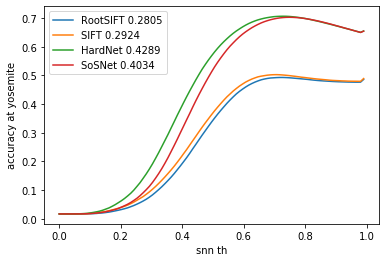

In [6]:
leg = []
for desc_name, res in results['yosemite'].items():
    plt.plot(res[0][:-1], res[1])
    acc = np.nan_to_num(np.array(res[1]), 0).mean()
    leg.append(f'{desc_name} {acc:.4f}')
plt.legend(leg)
plt.xlabel('snn th')
plt.ylabel('accuracy at yosemite')


In [ ]:
#from collections import defaultdict
#results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         K.feature.SIFTDescriptor(32, rootsift=True).to(torch.device('cuda:0')),
         K.feature.SIFTDescriptor(32, rootsift=False).to(torch.device('cuda:0')),
        K.feature.HardNet(True),
        K.feature.SOSNet(True)], ['RootSIFT', 'SIFT', 'HardNet', 'SoSNet']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name)
    break


notredame
RootSIFT
# Found cached data /home/old-ufo/datasets/Brown/notredame.pt
Extracting descriptors


Finding hard negatives
